<a href="https://colab.research.google.com/github/ketoin23/Handwritten-Text-Recognition/blob/main/HandwrittenTextRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -q https://git.io/J0fjL -O IAM_Words.zip
!unzip -qq IAM_Words.zip
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

In [ ]:
!head -30 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE
a01-000u-00-02 ok 154 796 764 70 50 TO to
a01-000u-00-03 ok 154 919 757 166 78 VB stop
a01-000u-00-04 ok 154 118

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [ ]:
word_list = []

words = open(f'data/words.txt', 'r').readlines()
for line in words:
  if(line[0] == '#'):
    continue
  if(line.split(' ')[1] != 'err'):
    word_list.append(line)

np.random.shuffle(word_list)

len(word_list)

96456

In [ ]:
word_list[0]

'g06-031l-05-10 ok 182 1807 1658 96 59 MD will\n'

In [ ]:
split_idx = int(0.9 * len(word_list))
split_idx
X = word_list[:split_idx]
y = word_list[split_idx:]

val_split_idx = int(0.5 * len(y))
validation = y[val_split_idx:]
y = y[:val_split_idx]

print(len(X))
print(len(y))
print(len(validation))

86810
4823
4823


In [ ]:
X[0]

'g06-031l-05-10 ok 182 1807 1658 96 59 MD will\n'

In [ ]:
base = 'data/words'

def get_path_labels(data):
  paths = []
  corrected_data = []

  for (i, line) in enumerate(data):
    line_clean = line.strip()
    line_clean = line_clean.split(' ')

    name = line_clean[0]
    part1 = name.split('-')[0]
    part2 = name.split('-')[1]

    img_path = os.path.join(base, part1, part1 + '-' + part2, name + '.png')

    if os.path.getsize(img_path):
      paths.append(img_path)
      corrected_data.append(line.split('\n')[0])
  
  return paths, corrected_data

In [ ]:
X_paths, X_labels = get_path_labels(X)
y_paths, y_labels = get_path_labels(y)
val_paths, val_labels = get_path_labels(validation)

In [ ]:
X_paths[0]

'data/words/g06/g06-031l/g06-031l-05-10.png'

In [ ]:
X_labels[0]

'g06-031l-05-10 ok 182 1807 1658 96 59 MD will'

In [ ]:
X[0]

'g06-031l-05-10 ok 182 1807 1658 96 59 MD will\n'

In [ ]:
def clean_labels(labels):
  cleaned_labels = []
  for label in labels:
    label = label.split(' ')[-1].strip()
    cleaned_labels.append(label)

  return cleaned_labels

In [ ]:
X_labels_clean = clean_labels(X_labels)
y_labels_clean = clean_labels(y_labels)
val_labels_clean = clean_labels(val_labels)   

In [ ]:
X_labels_clean[:10]

['will',
 'of',
 'remains',
 'there',
 'centigrade',
 'was',
 'said',
 '...',
 'and',
 'forced']

In [ ]:
characters = set()
max_len = 0

for label in X_labels_clean:
  for char in label:
    characters.add(char)
  
  max_len = max(max_len, len(label))

characters = sorted(list(characters))

In [ ]:
print(len(characters))
print(max_len)

78
21


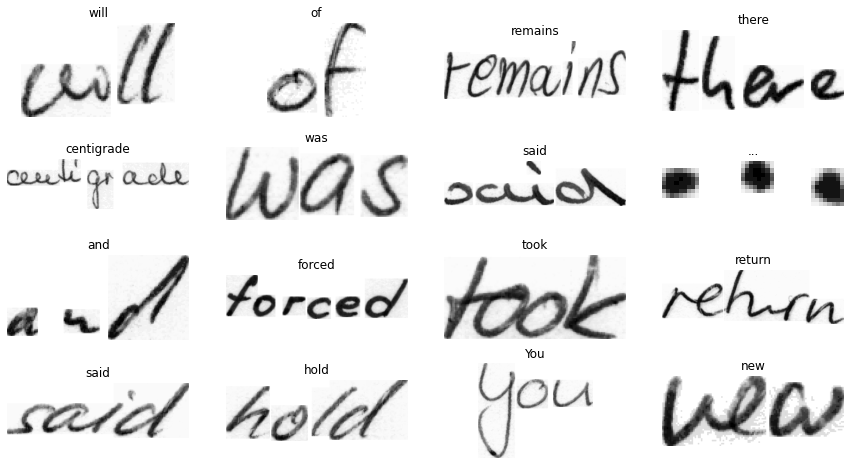

In [ ]:
import matplotlib.image as mpimg

_, ax = plt.subplots(4, 4, figsize=(15, 8))

for i in range(16):
  img = mpimg.imread(X_paths[i])
  ax[i // 4, i % 4].imshow(img, cmap="gray")
  ax[i // 4, i % 4].set_title(X_labels_clean[i])
  ax[i // 4, i % 4].axis("off")

plt.show()

In [ ]:
def distortion_free_resize(image, w, h):
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


In [ ]:
print(characters)

['!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=list(characters), mask_token=None)
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


In [ ]:
print(char_to_num('A'))

tf.Tensor(27, shape=(), dtype=int64)


In [ ]:
batch_size = 64
padding_token = 99
width = 128
height = 32

def preprocess_img(image_path):
  image = tf.io.read_file(image_path)
  image = tf.io.decode_png(image, 1)
  image = distortion_free_resize(image, width, height)
  image = tf.cast(image, tf.float32) / 255.0
  return image

def vectorize_label(label):
  label = char_to_num(tf.strings.unicode_split(label, input_encoding = "UTF-8"))
  length = tf.shape(label)[0]
  pad_amount = max_len - length
  label = tf.pad(label, paddings=[[0, pad_amount]], constant_values = padding_token)
  return label

def process_img_labels(image_path, label):
  image = preprocess_img(image_path)
  label = vectorize_label(label)
  #return (image, label)
  return {"image": image, "label": label}


In [ ]:
X_paths[:10]

['data/words/g06/g06-031l/g06-031l-05-10.png',
 'data/words/b04/b04-054/b04-054-04-04.png',
 'data/words/j04/j04-070/j04-070-00-01.png',
 'data/words/g06/g06-037i/g06-037i-03-05.png',
 'data/words/b03/b03-098/b03-098-06-00.png',
 'data/words/l01/l01-111/l01-111-00-05.png',
 'data/words/a01/a01-053u/a01-053u-00-01.png',
 'data/words/g06/g06-018k/g06-018k-07-09.png',
 'data/words/p02/p02-101/p02-101-04-09.png',
 'data/words/g01/g01-031/g01-031-06-04.png']

In [ ]:
X_labels_clean[:10]

['will',
 'of',
 'remains',
 'there',
 'centigrade',
 'was',
 'said',
 '...',
 'and',
 'forced']

In [ ]:
print(max_len)

21


In [ ]:
temp = vectorize_label(X_labels_clean[0])
print(X_labels_clean[0])
print(temp)

will
tf.Tensor([75 61 64 64 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99], shape=(21,), dtype=int64)


In [ ]:
temp = preprocess_img(X_paths[0])
print(X_paths[0])
print(temp)

data/words/g06/g06-031l/g06-031l-05-10.png
tf.Tensor(
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]], shape=(128, 32, 1), dtype=float32)


In [ ]:
print(temp[:, :, 0])

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(128, 32), dtype=float32)


In [ ]:
def prepare_dataset(image_paths, labels):
  dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
      process_img_labels
  )
  return dataset.batch(batch_size)

In [ ]:
train_ds = prepare_dataset(X_paths, X_labels_clean)
test_ds = prepare_dataset(y_paths, y_labels_clean)
val_ds = prepare_dataset(val_paths, val_labels_clean)

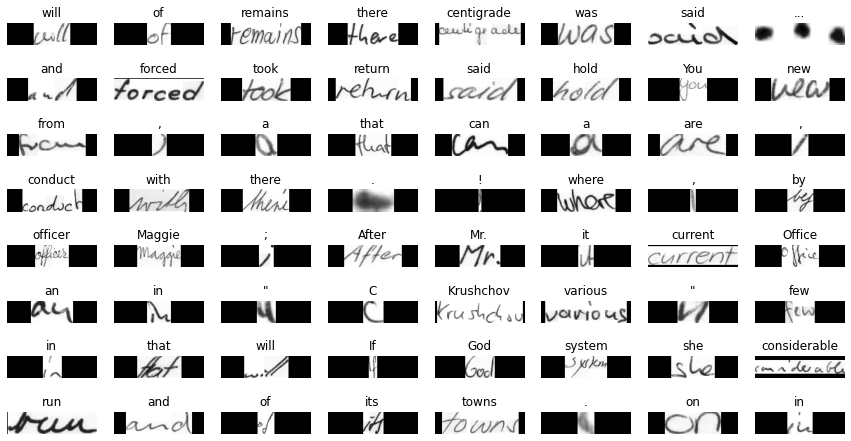

In [ ]:
for data in train_ds.take(1):
  images, labels = data['image'], data['label']

  _, ax = plt.subplots(8, 8, figsize = (15, 8))

  for i in range(64):
    img = images[i]
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img, perm=[1, 0, 2])
    img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]

    label = labels[i]
    indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
    label = tf.strings.reduce_join(num_to_char(indices))
    label = label.numpy().decode("utf-8")

    ax[i // 8, i % 8].imshow(img, cmap="gray")
    ax[i // 8, i % 8].set_title(label)
    ax[i // 8, i % 8].axis("off")

  plt.show()

In [ ]:
class CTCLayer(keras.layers.Layer):
  def __init__(self, name = None):
    super().__init__(name = name)
    self.loss_fn = keras.backend.ctc_batch_cost
  
  def call(self, y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype = 'int64')
    input_length = tf.cast(tf.shape(y_pred)[1], dtype = 'int64')
    label_length = tf.cast(tf.shape(y_true)[1], dtype = 'int64')

    input_length = input_length * tf.ones(shape = (batch_len, 1), dtype = 'int64')
    label_length = label_length * tf.ones(shape = (batch_len, 1), dtype = 'int64')
    loss = self.loss_fn(y_true, y_pred, input_length, label_length)
    self.add_loss(loss)

    return y_pred

In [ ]:
def build_model():
  #input
  input_img = keras.Input(shape = (width, height, 1), name = 'image')
  labels = keras.layers.Input(name = 'label', shape = (None,))

  #convolutional layers
  x = keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same', name = 'conv1')(input_img)
  x = keras.layers.MaxPooling2D((2, 2), name = 'pool1')(x)

  x = keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same', name = 'conv2')(x)
  x = keras.layers.MaxPooling2D((2, 2,), name = 'pool2')(x)

  new_shape = ((width // 4), (height // 4) * 64)
  x = keras.layers.Reshape(target_shape = new_shape, name = 'reshape')(x)
  x = keras.layers.Dense(64, activation = 'relu', name = 'dense1')(x)
  x = keras.layers.Dropout(0.2)(x)

  x = keras.layers.Bidirectional(
      keras.layers.LSTM(128, return_sequences = True, dropout = 0.25)
  )(x)
  x = keras.layers.Bidirectional(
      keras.layers.LSTM(64, return_sequences = True, dropout = 0.25)
  )(x)

  x = keras.layers.Dense(
      len(char_to_num.get_vocabulary()) + 2, activation = 'softmax', name = 'dense2'
  )(x)

  output = CTCLayer(name = 'ctc_loss')(labels, x)

  model = keras.models.Model(
      inputs = [input_img, labels], outputs = output, name = 'model'
  )

  opt = keras.optimizers.Adam()

  model.compile(optimizer = opt)
  return model

In [ ]:
val_images = []
val_labels = []

for batch in val_ds:
  val_images.append(batch['image'])
  val_labels.append(batch['label'])

In [ ]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['conv1[0][0]']                  
                                                                                                  
 conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0]']              

In [ ]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)

In [ ]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs,
)

Epoch 1/10
1357/1357 [==============================] - 929s 678ms/step - loss: 13.7298 - val_loss: 12.2912
Epoch 2/10
1357/1357 [==============================] - 921s 679ms/step - loss: 11.8116 - val_loss: 11.2098
Epoch 3/10
1357/1357 [==============================] - 927s 683ms/step - loss: 10.5299 - val_loss: 9.7676
Epoch 4/10
1357/1357 [==============================] - 934s 688ms/step - loss: 9.3496 - val_loss: 8.5553
Epoch 5/10
1357/1357 [==============================] - 928s 684ms/step - loss: 8.2311 - val_loss: 7.2442
Epoch 6/10
1357/1357 [==============================] - 923s 680ms/step - loss: 7.1222 - val_loss: 6.0947
Epoch 7/10
1357/1357 [==============================] - 914s 674ms/step - loss: 6.1501 - val_loss: 5.1096
Epoch 8/10
1357/1357 [==============================] - 915s 674ms/step - loss: 5.3800 - val_loss: 4.4883
Epoch 9/10
1357/1357 [==============================] - 915s 674ms/step - loss: 4.7799 - val_loss: 3.8407
Epoch 10/10
1357/1357 [==================

In [ ]:
def decode_pred(pred):
  input_len = np.ones(pred.shape[0]) * pred.shape[1]
  results = keras.backend.ctc_decode(pred, input_length = input_len, greedy = True)[0][0][:, :max_len]

  output_text = []
  for res in results:
    res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
    res = tf.strings.reduce_join(num_to_char(res)).numpy().decode('utf-8')
    output_text.append(res)
  
  return output_text


2/2 [==============================] - 2s 93ms/step


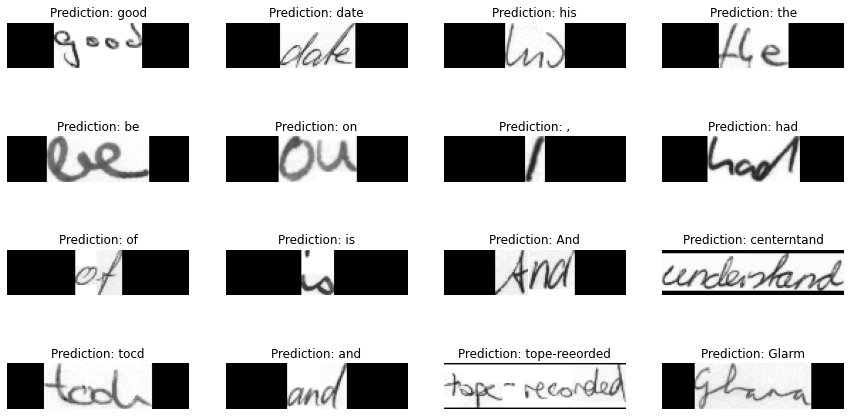

In [ ]:
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_pred(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [ ]:
model.save('HTR_ML.h5')